In [1]:
# Notebook display
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm_notebook

# PyTorch
import torch
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torch.hub import load_state_dict_from_url
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module, Sequential, Upsample, ReflectionPad2d, Conv2d, InstanceNorm2d, ReLU, MaxPool2d
import io


In [2]:
# Image size
SIZE = 512

# ImageNet statistics
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

# Determine device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pre-processing
def prep(image: bytes, size=SIZE, normalize=True, mean=MEAN, std=STD, device=DEVICE):
    image = Image.open(io.BytesIO(image))
    resize = transforms.Compose([transforms.Resize(size, Image.Resampling.LANCZOS),
                                 transforms.CenterCrop(size)])
    image = resize(image.convert('RGB'))
    if normalize:
        norm = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(mean, std)])
        return norm(image).unsqueeze(0).to(device)
    else:
        return image

# Post-processing
def post(tensor, mean=MEAN, std=STD):
    mean, std = torch.tensor(mean).view(3, 1, 1), torch.tensor(std).view(3, 1, 1)
    tensor = transforms.Lambda(lambda x: x * std + mean)(tensor.cpu().clone().squeeze(0))
    return transforms.ToPILImage()(tensor.clamp_(0, 1))

# Draw content, style and output images
def draw(input, content_image, style_image):
    output = post(input)

    clear_output(wait=True)
    plt.figure(figsize=(18, 6))

    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(prep(content_image, normalize=False))
    ax1.axis('off')
    ax1.set_title('Content Image')

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(prep(style_image, normalize=False))
    ax2.axis('off')
    ax2.set_title('Style Image')

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(output)
    ax3.axis('off')
    ax3.set_title('Output Image')

    plt.show()
    return output

In [2]:
import sys
sys.path.append('../')
from utils import DBHandler

In [3]:
from utils import DBHandler

In [4]:
db_handler = DBHandler()

Schema exists



In [6]:
db_handler.insert_picture_by_file(447558420, '../data/style2.jpg', 'style')

Updated


In [5]:
content_image, style_image = db_handler.extract_picture(447558420)

In [8]:
content, style = prep(content_image), prep(style_image)

c:\Users\Aleksey\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


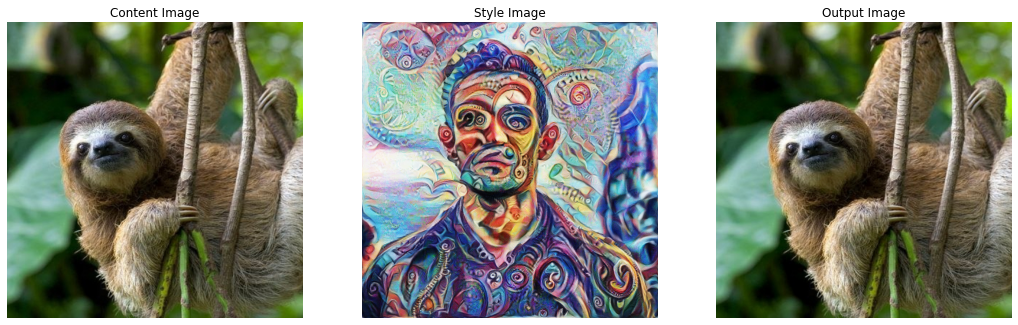

In [9]:
draw(content, content_image, style_image);

In [10]:
class ContentLoss(Module):
    def forward(self, features, targets):
        loss = F.mse_loss(features, targets)
        return loss


class StyleLoss(Module):
    def forward(self, features, GM_t):
        GM_f = self.gram_matrix(features)
        loss = F.mse_loss(GM_f, GM_t)
        return loss
    
    @staticmethod
    def gram_matrix(inputs):
        BS, C, H, W = inputs.size()
        inputs = inputs.view(BS, C, H * W)
        GM = inputs.bmm(inputs.transpose(1, 2))
        return GM.div_(C * H * W)

In [11]:
class ConvBlock(Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, norm=True, relu=True):
        super().__init__()

        self.upsample = Upsample(scale_factor=2) if upsample else None
        self.conv_block = Sequential(ReflectionPad2d(kernel_size // 2), Conv2d(in_channels, out_channels, kernel_size, stride))
        self.norm = InstanceNorm2d(out_channels, affine=True) if norm else None
        self.relu = ReLU(inplace=True) if relu else None

    def forward(self, x):
        if self.upsample:
            x = self.upsample(x)
        conv = self.conv_block(x)
        if self.norm:
            conv = self.norm(conv)
        if self.relu:
            conv = self.relu(conv)
        return conv


class ResBlock(Module):
    def __init__(self, channels):
        super().__init__()
        
        self.conv_blocks = Sequential(ConvBlock(channels, channels, kernel_size=3),
                                      ConvBlock(channels, channels, kernel_size=3, relu=False))

    def forward(self, x):
        return self.conv_blocks(x) + x


class ImageTransformationNetwork(Module):
    def __init__(self, num_res_blocks=5):
        super().__init__()

        self.transnet = Sequential(ConvBlock(3, 32, kernel_size=9, stride=1),
                                   ConvBlock(32, 64, kernel_size=3, stride=2),
                                   ConvBlock(64, 128, kernel_size=3, stride=2),
                                   *[ResBlock(128) for i in range(num_res_blocks)],
                                   ConvBlock(128, 64, kernel_size=3, upsample=True),
                                   ConvBlock(64, 32, kernel_size=3, upsample=True),
                                   ConvBlock(32, 3, kernel_size=9, norm=False, relu=False))

    def forward(self, x):
        return self.transnet(x)

In [12]:
transnet = ImageTransformationNetwork().to(DEVICE)

In [13]:
def transfer_style(transnet: Module, content: torch.Tensor):
    transnet.eval()
    with torch.no_grad():
        output = post(transnet(content))

        # output = draw(transnet(content), content_image, style_image)
    return output

# Run
transnet.load_state_dict(torch.load('../data/models/van_gogh.pth'))
output = transfer_style(transnet, content)

In [14]:
type(content)

torch.Tensor

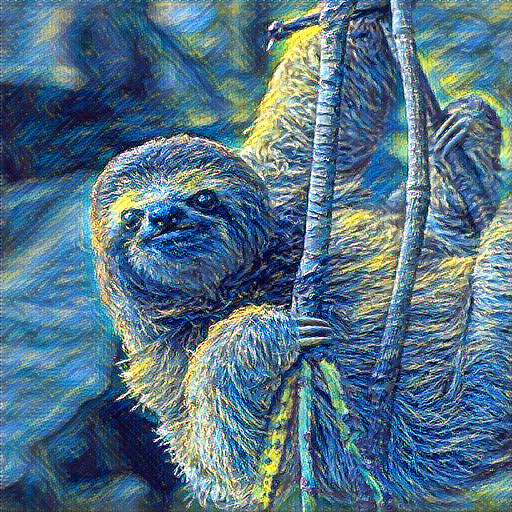

In [15]:
output

In [18]:
from image_methods import *
from IPython.display import Image as show_im

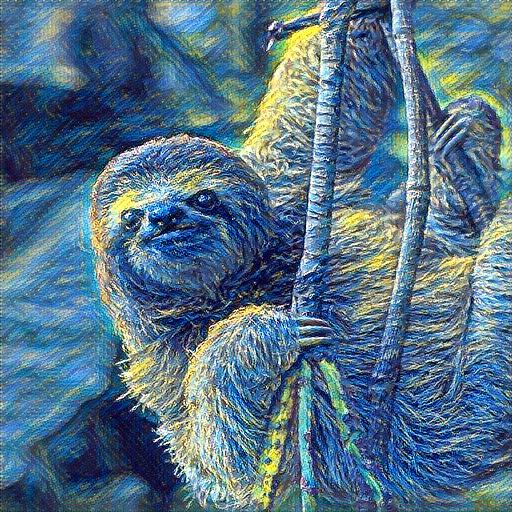

In [19]:
show_im(image_to_byte_array(output, cpu=True))

In [10]:
# Notebook display
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm_notebook
from image_methods import *
from IPython.display import Image as show_im
# PyTorch
import torch
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torch.hub import load_state_dict_from_url
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module, Sequential, Upsample, ReflectionPad2d, Conv2d, InstanceNorm2d, ReLU, MaxPool2d
import io


In [16]:
class ConvBlock(Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, norm=True, relu=True):
        super().__init__()

        self.upsample = Upsample(scale_factor=2) if upsample else None
        self.conv_block = Sequential(ReflectionPad2d(kernel_size // 2), Conv2d(in_channels, out_channels, kernel_size, stride))
        self.norm = InstanceNorm2d(out_channels, affine=True) if norm else None
        self.relu = ReLU(inplace=True) if relu else None

    def forward(self, x):
        if self.upsample:
            x = self.upsample(x)
        conv = self.conv_block(x)
        if self.norm:
            conv = self.norm(conv)
        if self.relu:
            conv = self.relu(conv)
        return conv


class ResBlock(Module):
    def __init__(self, channels):
        super().__init__()
        
        self.conv_blocks = Sequential(ConvBlock(channels, channels, kernel_size=3),
                                      ConvBlock(channels, channels, kernel_size=3, relu=False))

    def forward(self, x):
        return self.conv_blocks(x) + x


class ImageTransformationNetwork(Module):
    def __init__(self, num_res_blocks=5):
        super().__init__()

        self.transnet = Sequential(ConvBlock(3, 32, kernel_size=9, stride=1),
                                   ConvBlock(32, 64, kernel_size=3, stride=2),
                                   ConvBlock(64, 128, kernel_size=3, stride=2),
                                   *[ResBlock(128) for i in range(num_res_blocks)],
                                   ConvBlock(128, 64, kernel_size=3, upsample=True),
                                   ConvBlock(64, 32, kernel_size=3, upsample=True),
                                   ConvBlock(32, 3, kernel_size=9, norm=False, relu=False))

    def forward(self, x):
        return self.transnet(x)



class DefaultStylesTransformer():
    def __init__(self, content: bytes, stylization_type: str):
        super(DefaultStylesTransformer, self).__init__()
        assert stylization_type in {'picasso', 'vincent'}, "Don't know this style"
        self.stylization_type = stylization_type
        self.dir = '../data/models/van_gogh.pth' if stylization_type == 'vincent' \
                            else '../data/models/picasso.pth'
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.content = prep(content).to(self.device)
        self.transnet = ImageTransformationNetwork().to(self.device)
        self.transnet.load_state_dict(torch.load(self.dir))

    def transfer_style(self):
        self.transnet.eval()
        with torch.no_grad():
            output = post(self.transnet(self.content))

        return output        

In [17]:
transformer = DefaultStylesTransformer(content_image, 'vincent')

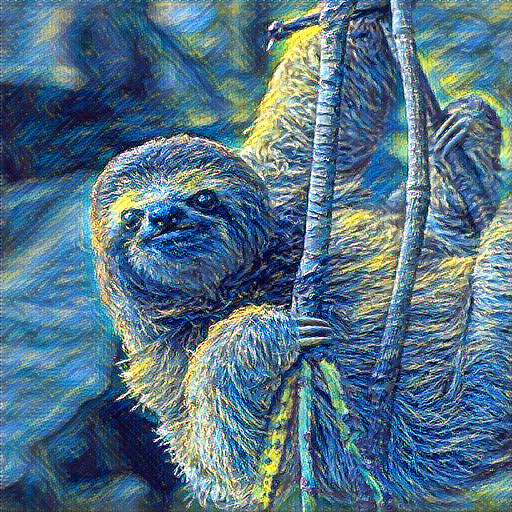

In [18]:
transformer.transfer_style()